In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

arch = resnet50
bs = 512
sz = 150
PATH = Path("data/plantvillage/multi")

In [3]:
disease_classes_multi = {
    'c_0': 'Apple Scab',
    'c_1': 'Apple Black_Rot',
    'c_2': 'Apple Cedar_Rust',
    'c_3': 'Apple healthy',
    'c_4': 'Blueberry healthy',
    'c_5': 'Cherry healthy',
    'c_6': 'Cherry Powdery_Mildew',
    'c_7': 'Corn Gray_Leaf_Spot',
    'c_8': 'Corn Common_Rust',
    'c_9': 'Corn healthy',
    'c_10': 'Corn Northern_Leaf_Blight',
    'c_11': 'Grape Black_Rot',
    'c_12': 'Grape Black_Measles',
    'c_13': 'Grape Healthy',
    'c_14': 'Grape Leaf_Blight',
    'c_15': 'Orange Huanglongbing_Citrus_Greening',
    'c_16': 'Peach Bacterial_Spot',
    'c_17': 'Peach healthy',
    'c_18': 'Bell_Pepper Bacterial_Spot',
    'c_19': 'Bell_Pepper healthy',
    'c_20': 'Potato Early_Blight',
    'c_21':  'Potato healthy',
    'c_22': 'Potato Late_Blight',
    'c_23': 'Raspberry healthy',
    'c_24': 'Soybean healthy',
    'c_25': 'Squash Powdery_Mildew',
    'c_26': 'Strawberry Healthy',
    'c_27': 'Strawberry Leaf_Scorch',
    'c_28': 'Tomato Bacterial_Spot',
    'c_29': 'Tomato Early_Blight',
    'c_30': 'Tomato Late_Blight',
    'c_31': 'Tomato Leaf_Mold',
    'c_32': 'Tomato Septoria_Leaf_Spot',
    'c_33': 'Tomato Two_Spotted_Spider_Mite',
    'c_34': 'Tomato Target_Spot',
    'c_35': 'Tomato Mosaic_Virus',
    'c_36': 'Tomato Yellow_Leaf_Curl_Virus',
    'c_37': 'Tomato healthy'
}

In [95]:
data = []
for d in PATH.glob('train/*.*'):
    data.append(str(d).split('/')[-2:])

In [96]:
data[:10]

[['train', '160672f7-d6a5-4aba-bb17-f6ecf0659013___RS_Rust 1685.JPG'],
 ['train', '57631e0d-3dc0-4fbf-932c-792937a0d450___RS_HL 0371.JPG'],
 ['train',
  '5d8b668e-5ab2-4a14-9b15-cdcbfce811b4___UF.Citrus_HLB_Lab 1529.JPG'],
 ['train', '2b6c6705-59ce-4afe-8ad1-62a367ea10e0___RS_HL 9994.JPG'],
 ['train', 'e1d54ad8-2b13-47fd-97da-1711decc24c4___Rut._Bact.S 1379.JPG'],
 ['train', 'e865c949-1448-44aa-bc40-2355215a8ea6___Rut._Bact.S 1529.JPG'],
 ['train', 'd208d8ad-aa94-4c86-b255-0bca480fdeea___RS_Rust 2494.JPG'],
 ['train', '7710d64d-83a3-46af-a9ff-535dd225523f___RS_HL 5788.JPG'],
 ['train', 'a948ae69-19b8-4b02-b2a9-35f819d39544___Rutg._Bact.S 1231.JPG'],
 ['train', '618dff3a-db0a-423c-a96c-d98f54e14083___RS_Rust 2706.JPG']]

In [16]:
train_data = []
for d in data:
    train_data.append([d[1], disease_classes_multi[d[0]].lower()])

In [17]:
train_data[:10]

[['bc2d6546-a407-4353-b903-93c5b68bfa2a___R.S_HL 8254 copy.jpg',
  'corn northern_leaf_blight'],
 ['650d4770-c4b9-4854-8476-681d9d93034c___R.S_HL 5557 copy.jpg',
  'corn northern_leaf_blight'],
 ['0618b46e-b4fb-4069-9b95-6c6c2387688a___R.S_HL 0609 copy 3.jpg',
  'corn northern_leaf_blight'],
 ['466155e6-ef86-4024-9c0a-de7ca09a1d07___R.S_HL 7986 copy.jpg',
  'corn northern_leaf_blight'],
 ['7b876e0e-d6bd-4b8c-952c-d0899053246c___R.S_HL 0604 copy 2.jpg',
  'corn northern_leaf_blight'],
 ['0ad1f85a-765f-43e5-8b7b-4a7521be768d___R.S_HL 5520 copy 2.jpg',
  'corn northern_leaf_blight'],
 ['764ab13c-df6b-44f5-993c-180aa14ed89f___R.S_HL 7911 copy 2.jpg',
  'corn northern_leaf_blight'],
 ['b1565e81-b8c3-4ba3-8b57-94395f82a3f2___R.S_HL 0595 copy 2.jpg',
  'corn northern_leaf_blight'],
 ['68a2cb35-42af-4760-ab0d-0abf06e2429a___R.S_HL 8270 copy 2.jpg',
  'corn northern_leaf_blight'],
 ['35e4b031-57a0-40b1-b234-d96324708a43___R.S_HL 8162 copy.jpg',
  'corn northern_leaf_blight']]

In [18]:
trn_df = pd.DataFrame(train_data, columns=['file', 'classes'])

In [21]:
trn_df.to_csv(PATH/'train_v1.csv', index=None, header=['file', 'classes'])

In [4]:
label_csv = PATH/'train_v1.csv'

In [5]:
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [6]:
def get_data(bs, sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms, val_idxs=val_idxs, test_name='test')
    return data if sz>300 else data.resize(sz, 'tmp')

In [7]:
data = get_data(bs, sz)

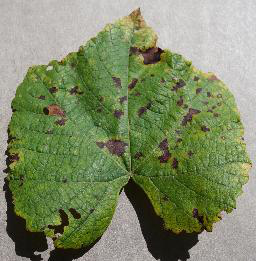

In [9]:
img = PIL.Image.open(str(PATH/data.trn_ds.fnames[1123])); img

In [16]:
size_d = {k: PIL.Image.open(str(PATH/k)).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

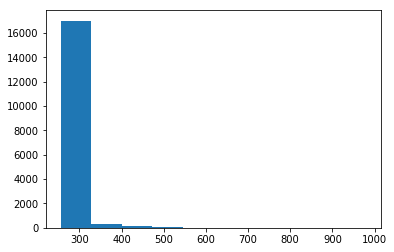

In [17]:
plt.hist(row_sz[row_sz<1000]);

In [10]:
x,y = next(iter(data.val_dl))

In [11]:
list(zip(data.classes, y[1]))

[('apple', 0.0),
 ('bacterial_spot', 0.0),
 ('bell_pepper', 0.0),
 ('black_measles', 0.0),
 ('black_rot', 0.0),
 ('blueberry', 0.0),
 ('cedar_rust', 0.0),
 ('cherry', 0.0),
 ('common_rust', 0.0),
 ('corn', 0.0),
 ('early_blight', 1.0),
 ('grape', 0.0),
 ('gray_leaf_spot', 0.0),
 ('healthy', 0.0),
 ('huanglongbing_citrus_greening', 0.0),
 ('late_blight', 0.0),
 ('leaf_blight', 0.0),
 ('leaf_mold', 0.0),
 ('leaf_scorch', 0.0),
 ('mite', 0.0),
 ('mosaic_virus', 0.0),
 ('northern_leaf_blight', 0.0),
 ('orange', 0.0),
 ('peach', 0.0),
 ('potato', 0.0),
 ('powdery_mildew', 0.0),
 ('raspberry', 0.0),
 ('scab', 0.0),
 ('septoria_leaf_spot', 0.0),
 ('soybean', 0.0),
 ('squash', 0.0),
 ('strawberry', 0.0),
 ('target_spot', 0.0),
 ('tomato', 1.0),
 ('two_spotted_spider', 0.0),
 ('yellow_leaf_curl_virus', 0.0)]

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
learn.lr_find(wds=1e-4,end_lr=100)

100%|██████████| 507/507 [02:27<00:00,  3.45it/s]


epoch      trn_loss   val_loss   <lambda>                    
    0      0.444488   1.598941   0.941162  



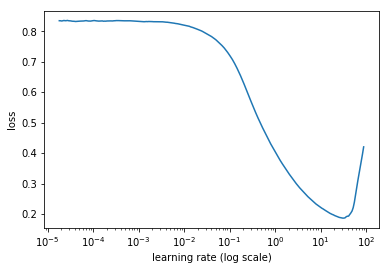

In [13]:
learn.sched.plot(10, 1)

In [14]:
lr = 5

In [15]:
learn.precompute = False

In [16]:
learn.fit(lr, 2, cycle_len=50, use_clr_beta=(10,13.68,0.95,0.85), wds=1e-4, cycle_save_name='shamba_bot_t2')

epoch      trn_loss   val_loss   <lambda>                     
    0      0.056257   0.035408   0.986945  
    1      0.04525    0.030281   0.989182                     
    2      0.042113   0.025684   0.99076                      
    3      0.04285    0.028252   0.989815                     
    4      0.04459    0.027131   0.990329                     
    5      0.044718   0.029051   0.989651                     
    6      0.045424   0.02806    0.99081                      
    7      0.044564   0.029586   0.989194                     
    8      0.049563   0.031428   0.988903                     
    9      0.049273   0.030362   0.989042                     
    10     0.048794   0.029599   0.989232                     
    11     0.049392   0.032752   0.988751                     
    12     0.050893   0.034049   0.987521                     
    13     0.050565   0.029787   0.989232                     
    14     0.048817   0.030385   0.989144                     
    15     

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    75     0.051503   0.031877   0.988662                     
    76     0.04876    0.031353   0.988966                     
    77     0.054468   0.035925   0.987071                     
    78     0.051251   0.030972   0.989283                     
    79     0.049374   0.033949   0.987331                     
 94%|█████████▍| 257/274 [01:24<00:05,  3.05it/s, loss=0.048] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    89     0.041968   0.023464   0.991824                     
    90     0.042103   0.02563    0.991495                     
    91     0.038145   0.023094   0.99256                      
    92     0.037253   0.022376   0.992972                     
    93     0.035952   0.021606   0.99287                      
    94     0.034699   0.019169   0.993992                     
 12%|█▏        | 33/274 [00:12<01:32,  2.61it/s, loss=0.0336]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
learn.save('pv_multi_shamba_bot_bs512_1cycle_lr3_acc_994')

In [29]:
learn.load('pv_multi_shamba_bot_bs512_1cycle_lr3_acc_994')

In [19]:
learn.lr_find()

epoch      trn_loss   val_loss   f2                           
    0      0.042299   0.093857   0.751458  



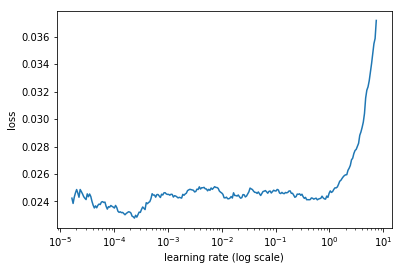

In [20]:
learn.sched.plot()

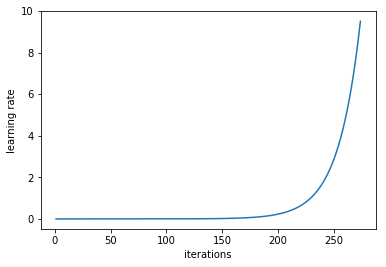

In [21]:
learn.sched.plot_lr()

In [22]:
sz = 224

In [18]:
learn.set_data(get_data(bs, sz))

In [19]:
learn.lr_find(wds=1e-4, end_lr=100)

 95%|█████████▍| 260/274 [01:25<00:04,  3.03it/s, loss=0.111] 

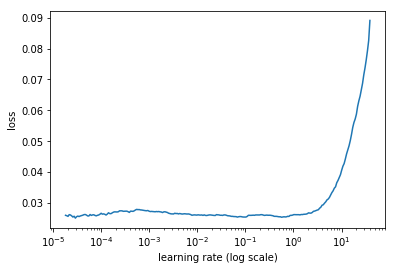

In [20]:
learn.sched.plot(10, 1)

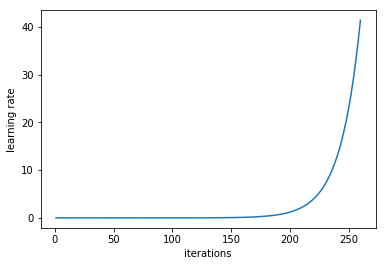

In [21]:
learn.sched.plot_lr()

In [ ]:
learn.unfreeze()
learn.fit([5e-9, 5e-4, 5e-1], 3, cycle_len=30, use_clr_beta=(20,10,0.95,0.85), wds=1e-4, best_save_name='pv_shamba_bot_unfrozen_bs512_1cycle')

  0%|          | 0/274 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   <lambda>                     
    0      0.044579   0.026473   0.990925  
    1      0.038142   0.022967   0.992281                     
    2      0.035847   0.021328   0.992832                     
    3      0.033501   0.020825   0.992972                     
    4      0.031397   0.01936    0.993479                     
    5      0.030087   0.018053   0.993897                     
    6      0.029119   0.017705   0.994379                     
 43%|████▎     | 119/274 [01:45<02:17,  1.13it/s, loss=0.0289]

In [23]:
final_accuracy = 998
learn.save(f'acc_pv_multilabel_1cycle_test_{sz}_bs_{bs}_{final_accuracy}')

In [24]:
learn.freeze()
learn.set_data(get_data(bs, 512))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.046903   0.080141   0.97804   



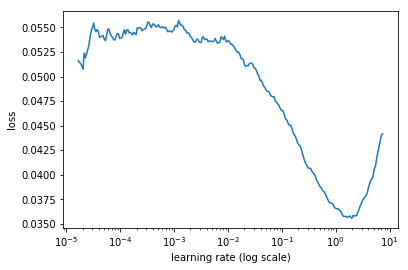

In [25]:
learn.lr_find()
learn.sched.plot()

In [26]:
lr = 0.7

In [ ]:
learn.fit(lr, 3, cycle_len=20, use_clr_beta=(20,10,0.95,0.85), wds=1e-4)

epoch      trn_loss   val_loss   <lambda>                     
    0      0.023676   0.014812   0.995855  
    1      0.020248   0.012718   0.996533                     
    2      0.018629   0.012119   0.996768                     
    3      0.017446   0.011966   0.996508                     
    4      0.018917   0.011691   0.996578                     
    5      0.017397   0.010807   0.996895                     
  4%|▎         | 10/274 [00:48<21:27,  4.88s/it, loss=0.0176] 

In [28]:
!/usr/bin/nvidia-smi

Wed May 30 06:36:50 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   79C    P0    89W / 149W |  10788MiB / 11439MiB |     77%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [29]:
learn.save('acc_pv_multilabel_final_998_lr7e1_1cycle_resize_x3')

In [30]:
log_preds, y = learn.TTA(n_aug=8)

In [69]:
accuracy_multi_np(log_preds, y, 0.5)

0.9982153268943139

In [ ]:
test_log_preds, test_y = learn.TTA(n_aug=8, is_test=True)

In [38]:
accuracy_multi_np(test_log_preds, test_y, 0.5)

0.9982153268943139

In [39]:
accuracy_multi_np??

In [ ]:
log_preds

In [41]:
learn.save('acc_pv_multilabel_final_998_lr5e3_1cycle_resize_x3_TTA_8aug')

In [102]:
def get_labels(a): return [data.classes[idx] for idx, o in enumerate(a) if o > 0.5]

In [63]:
len(data.classes)

36

In [64]:
len(log_preds)

10

In [70]:
len(log_preds[0])

4383

In [84]:
len(val_idxs)

4383

In [116]:
mean_preds = np.mean(log_preds, axis=0)

In [120]:
mean_preds[200]

array([0.00032, 0.0001 , 0.00013, 0.00035, 0.00041, 0.00035, 0.00032, 0.00027, 0.00055, 0.00106, 0.00018,
       0.00059, 0.00054, 0.00022, 0.9999 , 0.00047, 0.00055, 0.00021, 0.00034, 0.00025, 0.00019, 0.00054,
       0.9999 , 0.00013, 0.00095, 0.00018, 0.00028, 0.00038, 0.00016, 0.00029, 0.00024, 0.00026, 0.00015,
       0.00011, 0.00025, 0.00025], dtype=float32)

['apple', 'healthy']


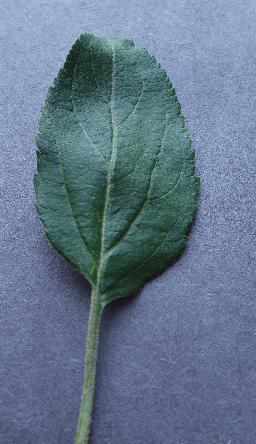

In [123]:
idx = 505
nth_preds = mean_preds[idx]
print(get_labels(nth_preds))
PIL.Image.open(PATH/data.val_dl.dataset.fnames[idx]).convert('RGB')

['early_blight', 'tomato']


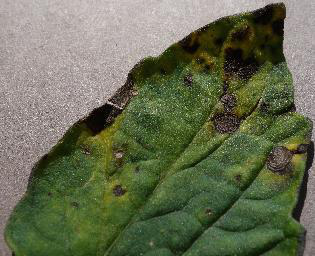

In [186]:
idx = 1
nth_preds = mean_preds[idx]
print(get_labels(nth_preds))
PIL.Image.open(PATH/data.val_dl.dataset.fnames[idx]).convert('RGB')

In [215]:
PATH

PosixPath('data/plantvillage/multi')

# Phone image tests

In [259]:
fn = 'screenshot2.png'
_, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)

In [260]:
preds

array([[0.00011, 0.00001, 0.00004, 0.04743, 0.00016, 0.00045, 0.00006, 0.00164, 0.00023, 0.0008 , 0.00008,
        0.57355, 0.00094, 0.00001, 0.00023, 0.00653, 0.00425, 0.04914, 0.00172, 0.00002, 0.00081, 0.00038,
        0.00023, 0.00001, 0.0007 , 0.00047, 0.00015, 0.0022 , 0.00209, 0.00002, 0.00003, 0.00034, 0.00008,
        0.13707, 0.00002, 0.00013]], dtype=float32)

['tomato']


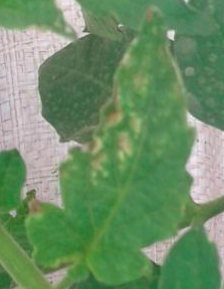

In [261]:
def get_highest_labels(a):
    plants = [0, 2, 5, 7, 9, 11, 22, 23, 24, 26, 29, 30, 31, 33]
    # plant_names = [data.classes[i] for i in plants]
    conditions = [i for i in range(0, 36) if i not in plants]
    # condition_names = [data.classes[i] for i in conditions]
    two_preds = [idx for idx in np.argpartition(-a, 2)[:2]]
    p1, p2 = two_preds
    final_preds = []
    if p1 in conditions:
        final_preds.append(data.classes[p1])
    if p2 in plants:
        final_preds.append(data.classes[p2])
    return final_preds

image_classes = get_highest_labels(preds[0])
print(image_classes)
PIL.Image.open(PATH/fn).convert('RGB')

In [242]:
list(zip(range(0, 36), data.classes))

[(0, 'apple'),
 (1, 'bacterial_spot'),
 (2, 'bell_pepper'),
 (3, 'black_measles'),
 (4, 'black_rot'),
 (5, 'blueberry'),
 (6, 'cedar_rust'),
 (7, 'cherry'),
 (8, 'common_rust'),
 (9, 'corn'),
 (10, 'early_blight'),
 (11, 'grape'),
 (12, 'gray_leaf_spot'),
 (13, 'healthy'),
 (14, 'huanglongbing_citrus_greening'),
 (15, 'late_blight'),
 (16, 'leaf_blight'),
 (17, 'leaf_mold'),
 (18, 'leaf_scorch'),
 (19, 'mite'),
 (20, 'mosaic_virus'),
 (21, 'northern_leaf_blight'),
 (22, 'orange'),
 (23, 'peach'),
 (24, 'potato'),
 (25, 'powdery_mildew'),
 (26, 'raspberry'),
 (27, 'scab'),
 (28, 'septoria_leaf_spot'),
 (29, 'soybean'),
 (30, 'squash'),
 (31, 'strawberry'),
 (32, 'target_spot'),
 (33, 'tomato'),
 (34, 'two_spotted_spider'),
 (35, 'yellow_leaf_curl_virus')]

In [237]:
plants = [0, 2, 5, 7, 9, 11, 22, 23, 24, 26, 29, 30, 31, 33]
plant_names = [data.classes[i] for i in plants]
conditions = [i for i in range(0, 36) if i not in plants]
condition_names = [data.classes[i] for i in conditions]

In [241]:
len(plant_names)#; plant_names

14

# CAM (Class activation Map)

A class activation map (CAM) is a heat-map of the contribution of a pixel in an image to the classification of that image. It is typically overlaid on top of an image, to see pixel level features contribute to its classification. Class-activation maps are constructed from a set of features in a trained model, which are saved during a single forward pass through that model. The set of features in this case should come from a group of three residual blocks that upsample the image, and one convolutional block whose output channel equals the number of classes in the dataset. To save the features, we use PyTorch hooks.

In [125]:
class SaveFeatures:
    features = None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [ ]:
plants = [0, 2, 5, 7, 9]

In [130]:
m = learn.model

In [126]:
x, y = next(iter(data.val_dl))

In [127]:
x, y = x[None, 1], y[None, 1]

In [128]:
vx = Variable(x.cuda(), requires_grad=True)

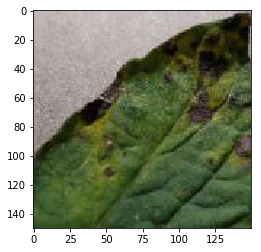

In [129]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [187]:
dx.shape

(150, 150, 3)

In [193]:
block_ends = [m[-14], m[-13], m[-12], m[-11]]

In [194]:
sfs = [SaveFeatures(o) for o in block_ends]

In [195]:
%time py = m(Variable(x.cuda()))

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.34 ms


In [196]:
for o in sfs:
    o.remove()

In [197]:
[o.features.size() for o in sfs]

[torch.Size([1, 256, 38, 38]),
 torch.Size([1, 512, 19, 19]),
 torch.Size([1, 1024, 10, 10]),
 torch.Size([1, 2048, 5, 5])]

In [198]:
exp_py = to_np(py)[0]; exp_py

array([0.     , 0.7769 , 0.16041, 0.     , 0.     , 0.     , 0.     , 0.     , 0.00001, 0.00027, 0.43583,
       0.00019, 0.00021, 0.01227, 0.00013, 0.00002, 0.00003, 0.     , 0.00002, 0.00001, 0.00002, 0.     ,
       0.00013, 0.00005, 0.04227, 0.     , 0.00001, 0.00001, 0.00002, 0.     , 0.     , 0.00011, 0.     ,
       0.04361, 0.00001, 0.00002], dtype=float32)

In [199]:
feat = np.maximum(0, to_np(sfs[3].features[0]))
feat.shape

(2048, 5, 5)

In [200]:
f2 = np.dot(np.rollaxis(feat, 0, 3), exp_py)
f2-=f2.min()
f2/=f2.max()
f2

ValueError: shapes (5,5,2048) and (36,) not aligned: 2048 (dim 2) != 36 (dim 0)

In [184]:
m[-2]

Linear(in_features=512, out_features=36, bias=True)

In [210]:
data.c

36

In [212]:
data.resize(224).path

 40%|███▉      | 12929/32388 [00:24<00:36, 526.92it/s]

OSError: [Errno 28] No space left on device

 40%|███▉      | 12929/32388 [00:39<01:00, 323.30it/s]